 ## <center>Practicing Machine Learning</center>
### <center>Classification Exercise </center>
### <center>Spam Classifier </center>
#### <center> Recommended Source: <a href="https://www.amazon.com/-/es/Aur%C3%A9lien-G%C3%A9ron/dp/1492032646/ref=sr_1_fkmr1_1?__mk_es_US=%C3%85M%C3%85%C5%BD%C3%95%C3%91&crid=2Y7BISU0SQYCV&keywords=hand+son+machine+learning+tensorflow+keras&qid=1664596219&qu=eyJxc2MiOiIwLjkzIiwicXNhIjoiMC4wMCIsInFzcCI6IjAuMDAifQ%3D%3D&sprefix=hand+son+machine+learning+tensorflow+keras%2Caps%2C105&sr=8-1-fkmr1">Link</a></center>

## Loading the Data
For this practice I will download the spamassassin dataset from apache.org.

In [2]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

def fetch_spam_data(spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", HAM_URL), ("spam.tar.bz2", SPAM_URL)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=SPAM_PATH)
        tar_bz2_file.close()

fetch_spam_data()

Now that I have the data let's start working on it, in this case we have unstructured data and I require for it to be in a structured easy to work way. For this I like to use pandas DataFrames so on the next segment of code I extract all filenames and create a list labeled by if spam or ham emails.

In [3]:
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR))]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR))]

ham_filenames

['00001.7c53336b37003a9286aba55d2945844c',
 '00002.9c4069e25e1ef370c078db7ee85ff9ac',
 '00003.860e3c3cee1b42ead714c5c874fe25f7',
 '00004.864220c5b6930b209cc287c361c99af1',
 '00005.bf27cdeaf0b8c4647ecd61b1d09da613',
 '00006.253ea2f9a9cc36fa0b1129b04b806608',
 '00007.37a8af848caae585af4fe35779656d55',
 '00008.5891548d921601906337dcf1ed8543cb',
 '00009.371eca25b0169ce5cb4f71d3e07b9e2d',
 '00010.145d22c053c1a0c410242e46c01635b3',
 '00011.fbcde1b4833bdbaaf0ced723edd6e355',
 '00012.48a387bc38d1316a6f6b49e8c2e43a03',
 '00013.81c34741dbed59c6dde50777e27e7ea3',
 '00014.cb20e10b2bfcb8210a1c310798532a57',
 '00015.4d7026347ba7478c9db04c70913e68fd',
 '00016.ef397cef16f8041242e3b6560e168053',
 '00017.08ef2d89f14cf7e2a458b80697eb1837',
 '00018.6fee38026193b5adde4b56892a6f14bc',
 '00019.5322cb10d8819b39499924d852819c27',
 '00020.d10651e31fcb92630c6229ec773cfe26',
 '00021.607c41268c5b0d66e81b58713a66d12c',
 '00022.48098f942c31097d2ef605df44dd8593',
 '00023.e0e815ea1d7fd40e7e70b4c0035bef0c',
 '00024.59c

In [42]:
len(spam_filenames)

501

Now we can see that we have two lists, of lengths 2501 and 501, this is the first bit of exploration I did since I now know that I'm working with an unbalanced dataset and need to mend that during my data preparation phase.

In [43]:
ham_filenames[:5]

['00001.7c53336b37003a9286aba55d2945844c',
 '00002.9c4069e25e1ef370c078db7ee85ff9ac',
 '00003.860e3c3cee1b42ead714c5c874fe25f7',
 '00004.864220c5b6930b209cc287c361c99af1',
 '00005.bf27cdeaf0b8c4647ecd61b1d09da613']

In [44]:
spam_filenames[:5]

['00001.7848dde101aa985090474a91ec93fcf0',
 '00002.d94f1b97e48ed3b553b3508d116e6a09',
 '00003.2ee33bc6eacdb11f38d052c44819ba6c',
 '00004.eac8de8d759b7e74154f142194282724',
 '00005.57696a39d7d84318ce497886896bf90d']

In [45]:
import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

In [46]:
ham_emails[:5]

In [47]:
spam_emails[:5]

Using the "email" module that comes with python I was able to parce these files and get all emails into two lists of email objects. This is usefull but totally useless at this moment in time. now what I need to do is to convert to a pandas dataframe and leverage pandas capabilities to transform this data into usable text.

In [48]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

spam_array = np.array(spam_emails, dtype=object)
ham_array = np.array(ham_emails, dtype=object)
spam_df = pd.DataFrame(spam_array, columns=['email'])
ham_df = pd.DataFrame(ham_array, columns=['email'])
spam_df['Category'] =  1
ham_df['Category'] =  0
data = spam_df.append(ham_df)
len(data)


C:\Users\Usuario1\AppData\Local\Temp\ipykernel_30664\432255955.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = spam_df.append(ham_df)


3002

Done!. We now have a dataframe with all email data but still is unusable now I will define helper functions that will not only extract email data like subject and email body but also parse it and remove unusable garbage text like "emojis".

In [49]:
import re
from html import unescape
import string

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', ' ', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', ' ', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

In [50]:
def get_email_content(email):
    parts = []
    for part in email.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
        if part.get_content_type() == 'text/html':
            parts.append( part.get_payload() )
    return html_to_plain_text(' '.join(parts)).replace('\n',' ').replace('�',' ').translate(str.maketrans(' ', ' ', string.punctuation))

In [51]:
def prepare_dataset(df):
    df['Content'] = df['email'].map(lambda x: x['Subject']) + df['email'].map(lambda x: get_email_content(x))
    return df[['Category', 'Content']].copy()
email_data = prepare_dataset(data.copy()).sample(frac=1)
email_data.head(1)

,Category,Content
119,1,Join the Web's Hottest & Fastest Growing Commu...


Easy enough I now have 3 things:
<ol type="1">
    <li>A way to get email content like subject and body in one unified text column</li>
    <li>A way of parsing html to convert to plain text</li>
    <li>Create a dictionary with all possible words as keys</li>
    <li>A way to store each text into a pandas column in my dataframe</li>
</ol>

Is this enough? No. I mentioned before that this was an unbalanced dataset see below how imbalanced our classes are


<AxesSubplot: >

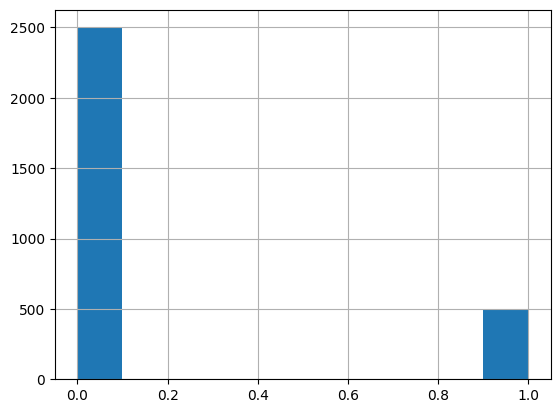

In [52]:
email_data.Category.hist()

Now that we have confirmed our suspicions lets take a step further and fix it using RandomOverSampling() from imblearn framework to level our classes and provide balance to our dataset. Over Sampling is one way to fix balance in a dataset, it creates "mock", "dummy" usable data based on current data in order to have enough data for each class.

In [53]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1989)
X = email_data[['Content']]
y = email_data.Category
X_resampled, y_resampled =  ros.fit_resample(X, y)

Done!, now let's see how it looks now.

<AxesSubplot: >

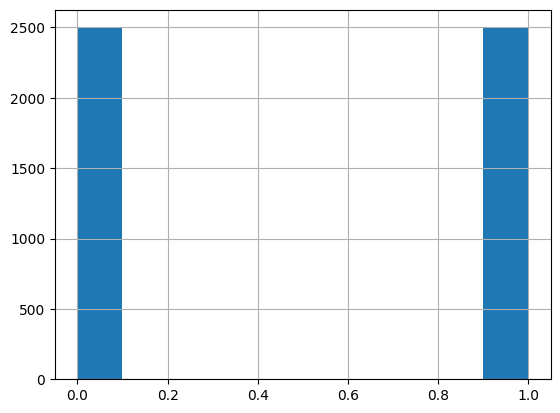

In [54]:
y_resampled.hist()

In [55]:
X_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5002 entries, 0 to 5001
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Content  4996 non-null   object
dtypes: object(1)
memory usage: 39.2+ KB


Awesome!. I have now a dataset in a structured form. Or do I??? text is another form of unstructured data and will prove problematic or unusable at best to train basic ML models.

## Data Preparation
For text data to be useable on a model we need to translate the text into usable features. For this I will be converting the Subject and the Body into feature Vectors for any model to use to learn and predict.

This process will require creating a corpus off of all our email contents. I will be creating a custom data transformer that does the following:
<ol type="1">
    <li>Remove punctuation from text</li>
    <li>Remove stop words and trash text</li>
    <li>Create a list with all possible words found in the text</li>
    <li>Remove duplicate words by converting to a set</li>
    <li>Create a dictionary with all possible words as keys, also known as "corpus" in NLP</li>
    <li>Count the frequency of each word in our column</li>
    <li>Create a vector that will represent the text</li>
    <li>Create a new dataframe with all vectors in rows and all columns are the corpus keys</li>
</ol>

In [56]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailDataExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, ):
        self.corpus = {}
        self.stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

    def fit(self, X, y=None):
        for text in X.Content.values:
            keys = set(text.split())
            for key in keys:

                if 'http' not in key and  key not in self.corpus.keys() and len(key) > 1 and key not in self.stop_words:
                    self.corpus[key] = 0
        return self
    def transform(self, X):
        content_vector = []

        for text in X.Content:

            keys = set(text.split())
            frequencies = self.corpus.copy()
            for key in keys:
                if key in self.corpus.keys():
                    frequencies[key] += 1
            content_vector.append(frequencies)
        return pd.DataFrame(content_vector, columns=frequencies.keys())



In [57]:
X_resampled.fillna("",inplace=True)
email_data_transformer = EmailDataExtractor().fit(X_resampled)

X_vectorized = email_data_transformer.transform(X_resampled)

In [58]:
X_vectorized.head(1)

,Growing,Hot,Have,Day,Patches,Free,30,Join,Child,Slim20,...,Randolph,Elliott,SixDegress,SixDegreesURL,hard-drive,Data-mine,Navigate,datamines,misfiles,selfupdating
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


Now that our text has been structured into usable data for our traditional ML models. we still have to ensure that our class proportions are ok for training, for this, I will use my favorite splitting function "StratifiedShuffleSplit" which will allow me to train my model without adding bias by randomly splitting without regard for dataset balance.

In [59]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1989)
for train_index, test_index in split.split(X_vectorized, y_resampled):
    X_train_set = X_vectorized.loc[train_index]
    X_test_set = X_vectorized.loc[test_index]
    y_train_set = y_resampled.loc[train_index]
    y_test_set = y_resampled.loc[test_index]

<AxesSubplot: >

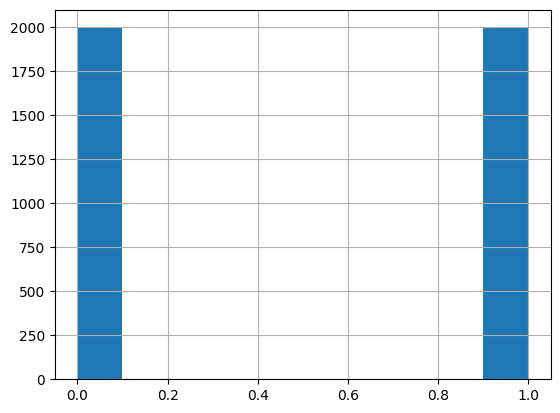

In [60]:
y_train_set.hist()

Classes are balanced!, we can now proceed to my favorite phase Modelling.

## ML Modelling

My first choice of model is obviously due to the fact that this problem is a binary classification problem. Logistic Regression is an awesome simple binary classifier that I love BTW, let's see how well it fairs now.

In [61]:
from sklearn.linear_model import LogisticRegression

logistic_reg_model = LogisticRegression()
logistic_reg_model.fit(X_train_set, y_train_set)

LogisticRegression()

In [62]:

logistic_reg_model.predict([X_test_set.loc[3892]])


C:\Users\Usuario1\anaconda3\envs\Machine Learning Topics Explanation\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([1], dtype=int64)

In [63]:
print(y_test_set.loc[3892])

1


Hmmm apparently my model is able to predict correctly but I'm more interested in following good practices and see metrics so let's try "cross validation" just in case we need to address overfitting and measure our performance using my very loved "f1 score"

In [64]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score
y_pred = cross_val_predict(logistic_reg_model, X_train_set, y_train_set, cv=8, method='predict')
f1_score(y_train_set, y_pred)

0.9970014992503748

Incredible although I still want to see if this persists through unseen data since I might have Overfitting here.

In [65]:
y_pred = cross_val_predict(logistic_reg_model, X_test_set, y_test_set, cv=8, method='predict')
f1_score(y_test_set, y_pred)

0.9828801611278952

Awesome!, my model worked beautifully meaning that I probably do not have to worry about overfitting issues. Now I will use KNeirest Neighbors model to do the same solution and compare results

In [66]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_set, y_train_set)

KNeighborsClassifier()

In [67]:

knn_clf.predict([X_test_set.loc[3892]])


C:\Users\Usuario1\anaconda3\envs\Machine Learning Topics Explanation\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([1], dtype=int64)

Again it seems to be able to predict correctly, but  let's take a look at the combination of "cross validation" and "f1 score"

In [68]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score
y_pred = cross_val_predict(knn_clf, X_train_set, y_train_set, cv=8, method='predict')
f1_score(y_train_set, y_pred)

0.7314933284591483

Hmmm interesting our model has a low performance on our training set, this might be underfitting, model not being appropriate for this so let's just check on our test set

In [69]:
y_pred = cross_val_predict(logistic_reg_model, X_test_set, y_test_set, cv=8, method='predict')
f1_score(y_test_set, y_pred)

0.9828801611278952

Fascinating!, apparently it behaved much better on our test set, I do not like this since the training f1 score might indicate unstable behavior for new data in the future.

## Conclusion
Logistic Regression is the solid winner at solving this binary classification problem!.